In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [1]:
from utils import *
import pickle

mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq_fixed/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        (np.array([ts[i][order2[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts[i][order1[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts2[i][order2[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2,
                                        (np.array([ts2[i][order1[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
    # with open("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", "wb") as f:
    #     pickle.dump(x_array, f)

on ... 0 0 qq
on ... 0 0 qqq
on ... 0 0.5 qq
on ... 0 0.5 qqq
on ... 0 1 qq
on ... 0 1 qqq
on ... 0 1.5 qq
on ... 0 1.5 qqq
on ... 0 2 qq
on ... 0 2 qqq
on ... 0 2.5 qq
on ... 0 2.5 qqq
on ... 0 3 qq
on ... 0 3 qqq
on ... 0 3.5 qq
on ... 0 3.5 qqq
on ... 0 4 qq
on ... 0 4 qqq
on ... 0 4.5 qq
on ... 0 4.5 qqq
on ... 0 5 qq
on ... 0 5 qqq
on ... 0 5.5 qq
on ... 0 5.5 qqq
on ... 0 6 qq
on ... 0 6 qqq
on ... 0.5 0 qq
on ... 0.5 0 qqq
on ... 0.5 0.5 qq
on ... 0.5 0.5 qqq
on ... 0.5 1 qq
on ... 0.5 1 qqq
on ... 0.5 1.5 qq
on ... 0.5 1.5 qqq
on ... 0.5 2 qq
on ... 0.5 2 qqq
on ... 0.5 2.5 qq
on ... 0.5 2.5 qqq
on ... 0.5 3 qq
on ... 0.5 3 qqq
on ... 0.5 3.5 qq
on ... 0.5 3.5 qqq
on ... 0.5 4 qq
on ... 0.5 4 qqq
on ... 0.5 4.5 qq
on ... 0.5 4.5 qqq
on ... 0.5 5 qq
on ... 0.5 5 qqq
on ... 0.5 5.5 qq
on ... 0.5 5.5 qqq
on ... 0.5 6 qq
on ... 0.5 6 qqq
on ... 1 0 qq
on ... 1 0 qqq
on ... 1 0.5 qq
on ... 1 0.5 qqq
on ... 1 1 qq
on ... 1 1 qqq
on ... 1 1.5 qq
on ... 1 1.5 qqq
on ... 1 2 qq
on ... 1

In [4]:
import pickle
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
x = {}
with open("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", "rb") as f:
    x_array_read = pickle.load(f)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qq, False] = x_array_read[mycounter]

In [5]:
qq = "qq"

In [11]:
x[1,1, qq, False]

array([[-1.1467854 , -1.47770924, -0.06188168, -1.25308806,  0.34378257,
        -0.18466159],
       [-1.1487145 , -1.69706728, -0.68294717,  0.03500569, -1.06319069,
         0.43469069],
       [-1.13268386, -1.55028145, -1.34432782, -0.39714657, -0.953696  ,
        -1.60115472],
       ...,
       [-1.17579285, -1.62957953, -0.78923019, -1.31430044, -1.73511428,
        -0.82381764],
       [-1.19046974, -1.71033063, -0.4539729 ,  0.11360652, -0.80338618,
         0.44749405],
       [-1.23125368, -1.64679808, -1.99324816, -1.64119963, -0.33379286,
         0.3691295 ]])

In [18]:
np.shape(x_array[0])

(76373, 6)

In [5]:
test = np.load("W_q_100_100_high_level_features.npy", allow_pickle = True)
np.shape(test)

(76373, 6)

In [6]:
test

array([[0.150308  , 0.52540458, 0.78506277, 0.104488  , 0.28992314,
        0.69563436],
       [0.111077  , 0.40405614, 0.60229282, 0.104146  , 0.5344167 ,
        0.77031775],
       [0.139942  , 0.45214252, 0.51136438, 0.106988  , 0.27537547,
        0.6197377 ],
       ...,
       [0.118241  , 0.27804457, 0.61225863, 0.0993454 , 0.39046139,
        0.53739188],
       [0.101323  , 0.54995058, 0.77340149, 0.0967434 , 0.4528955 ,
        0.64811971],
       [0.105356  , 0.21591626, 0.76569951, 0.089513  , 0.15151533,
        0.75239603]])

In [7]:
qq = "qq"
qqq = "qqq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
def load_data(filename, noise_dims):

    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for q in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,q, False] = x_array_read[mycounter]

                if noise_dims and qq == "qq":
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
            
x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", noise_dims = 0)

In [28]:
np.shape(x[0,0, qq, True])

(121352, 16)

In [4]:
np.shape(x[0,0, qq, False])

(121352, 6)

In [44]:
np.shape(x[0,0, qqq, False])

(121352, 6)

In [24]:
x_data_qq = []
y_data_qq = []
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qq']:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qq = np.concatenate([x_data_qq,x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([y_data_qq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [29]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_fixed", x_data_qq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_fixed", y_data_qq)

In [12]:
x_data_qq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_fixed.npy")
y_data_qq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_fixed.npy")

In [9]:
x_data_qq = np.load("data/x_parametrized_data_qq.npy")
y_data_qq = np.load("data/y_parametrized_data_qq.npy")

In [9]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_data_qq, y_data_qq, test_size=0.5, random_state = 42)

In [10]:
X_train_qq

array([[-1.29067761, -1.49584945,  1.523089  , ..., -0.33863646,
         3.        ,  4.5       ],
       [-0.9812558 , -0.0741258 , -1.56602011, ...,  0.2154482 ,
         1.        ,  4.        ],
       [-1.5053652 , -1.46572857,  2.1232833 , ...,  1.16977851,
         2.        ,  5.5       ],
       ...,
       [-1.33821732,  0.60248958, -0.35903133, ..., -0.80362504,
         5.5       ,  1.5       ],
       [-1.1929567 , -0.94234964, -0.89993095, ...,  0.49589514,
         3.5       ,  6.        ],
       [-1.21768687, -0.23171448, -0.45549635, ...,  0.50476543,
         5.5       ,  1.        ]])

In [11]:
# x_data_qqq = np.load("x_data_qqq.npy")
# y_data_qqq = np.load("y_data_qqq.npy")

In [383]:
np.shape(x_data_qq)

(27249420, 8)

In [12]:
import wandb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from wandb.keras import WandbCallback


pscratch_dir = "/pscratch/sd/g/gupsingh/"
os.environ["WANDB_DIR"] = pscratch_dir

config = {
    "layer_1_neurons": 256,
    "layer_2_neurons": 128,
    "layer_3_neurons": 64,
    "output_neurons": 1,
    "activation": "relu",
    "output_activation": "sigmoid",
    "optimizer": "adam",
    "learning_rate": 0.0001,
    "loss": "binary_crossentropy",
    "epochs": 5000,
    "batch_size": 1024
}

wandb.init(project="SemiWeakly", 
           group="Parametrized", 
           entity='gup-singh',
           mode = 'online',
           config=config)

config = wandb.config
run_name = wandb.run.name

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def train_parametrized(X_train, Y_train, X_val, Y_val, config, return_history=False):
    model_parametrized = Sequential()
    model_parametrized.add(Dense(config["layer_1_neurons"], input_dim=np.shape(X_train_qq)[1], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_2_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_3_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config.output_neurons, activation=config["output_activation"]))
    model_parametrized.compile(loss=config["loss"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['accuracy'])

    with tf.device('/GPU:0'):
        history_parametrized = model_parametrized.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), batch_size=config.batch_size, callbacks=[es, WandbCallback()])
        
    if return_history:
        return model_parametrized, history_parametrized.history
    else:
        return model_parametrized

model_parametrized, history_parametrized = train_parametrized(X_train_qq, Y_train_qq, X_val_qq, Y_val_qq, config, return_history=True)

wandb.finish()

model_parametrized.save(pscratch_dir + run_name)
#model_parametrized.save(pscratch_dir+"normal")
num_epochs = len(history_parametrized["loss"])
val_accuracy = model_parametrized['val_accuracy'][-1]
send_slack_message(f"Notebook Parametrized Training Finished - Epochs: {num_epochs} - Validation Accuracy: {val_accuracy}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ServiceStartTimeoutError: Timed out waiting for wandb service to start after 30.0 seconds. Try increasing the timeout with the `_service_wait` setting.

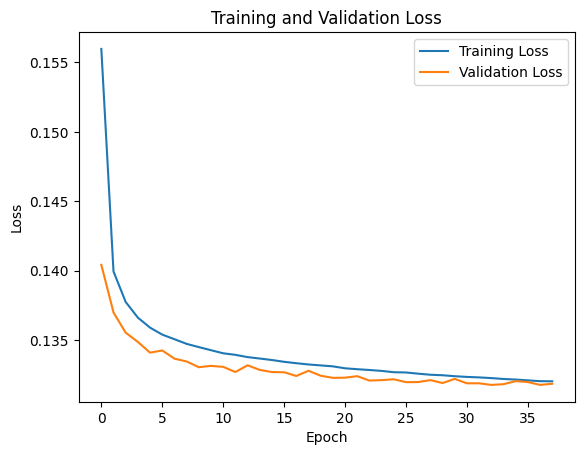

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


Plot sent successfully: None


In [15]:
#Diagonistic Plot
plt.figure()
plt.plot(history_parametrized['loss'], label='Training Loss')
plt.plot(history_parametrized['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
img_path = "plots/parametrized_trainingloss.png"
plt.savefig(img_path)
plt.legend()
plt.show()

from utils import send_slack_plot
send_slack_plot(img_path)

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(X_train_qq, Y_train_qq, epochs=5000,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024,callbacks=[es])

Epoch 1/5000


2024-02-13 11:35:54.469759: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd0d47d1850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-13 11:35:54.469776: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-13 11:35:54.469780: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-13 11:35:54.469783: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-13 11:35:54.469786: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-13 11:35:54.581650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-13 11:3

2662/2662 [==============================] - 17s 5ms/step - loss: 0.2471 - accuracy: 0.9057 - val_loss: 0.2032 - val_accuracy: 0.9237
Epoch 2/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1930 - accuracy: 0.9269 - val_loss: 0.1833 - val_accuracy: 0.9298
Epoch 3/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1779 - accuracy: 0.9314 - val_loss: 0.1725 - val_accuracy: 0.9332
Epoch 4/5000
2169/2662 [=======================>......] - ETA: 1s - loss: 0.1700 - accuracy: 0.9341

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/wandb/__main__.py", line 3, in <module>
    cli.cli(prog_name="python -m wandb")
  File "/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/click/

2662/2662 [==============================] - 11s 4ms/step - loss: 0.1695 - accuracy: 0.9343 - val_loss: 0.1662 - val_accuracy: 0.9355
Epoch 5/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1642 - accuracy: 0.9363 - val_loss: 0.1617 - val_accuracy: 0.9371
Epoch 6/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1602 - accuracy: 0.9379 - val_loss: 0.1581 - val_accuracy: 0.9387
Epoch 7/5000
2662/2662 [==============================] - 10s 4ms/step - loss: 0.1570 - accuracy: 0.9392 - val_loss: 0.1553 - val_accuracy: 0.9399
Epoch 8/5000
2662/2662 [==============================] - 10s 4ms/step - loss: 0.1545 - accuracy: 0.9403 - val_loss: 0.1531 - val_accuracy: 0.9408
Epoch 9/5000
2662/2662 [==============================] - 10s 4ms/step - loss: 0.1525 - accuracy: 0.9410 - val_loss: 0.1512 - val_accuracy: 0.9415
Epoch 10/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1508 - accuracy: 0.9417 - val_loss: 0.1497 - val_

In [57]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_normal = Sequential()
model_normal.add(Dense(128, input_dim=8, activation='relu'))
model_normal.add(Dense(128, activation='relu'))
model_normal.add(Dense(128, activation='relu'))
model_normal.add(Dense(1, activation='sigmoid'))
model_normal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_normal = model_normal.fit(X_train_qq, Y_train_qq, epochs = 1000, validation_data=(X_val_qq, Y_val_qq), batch_size=5*1024, callbacks = [es])

Epoch 1/1000
2662/2662 [==============================] - 9s 3ms/step - loss: 0.1617 - accuracy: 0.9368 - val_loss: 0.1434 - val_accuracy: 0.9443
Epoch 2/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1387 - accuracy: 0.9463 - val_loss: 0.1382 - val_accuracy: 0.9466
Epoch 3/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1362 - accuracy: 0.9472 - val_loss: 0.1359 - val_accuracy: 0.9473
Epoch 4/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1351 - accuracy: 0.9475 - val_loss: 0.1344 - val_accuracy: 0.9479
Epoch 5/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1344 - accuracy: 0.9478 - val_loss: 0.1357 - val_accuracy: 0.9473
Epoch 6/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1339 - accuracy: 0.9480 - val_loss: 0.1364 - val_accuracy: 0.9468
Epoch 7/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1335 - accuracy: 0.9481 - val_loss: 0.1341 -

In [29]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94709
best_epoch,41
best_val_loss,0.13607
epoch,41
loss,0.1365
val_accuracy,0.94731


In [15]:
model_qq.save(pscratch_dir + "model_fixed")

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


In [13]:
#model_qq = tf.keras.models.load_model("model_qq_v2")
#model_qq = tf.keras.models.load_model("model_qq_opt2")
#model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/neat-tree-47")
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
#model_qq = tf.keras.models.load_model("model_qq_noisy10")

2024-02-13 13:48:21.126299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79099 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [19]:
qq = 'qq'
noise = False

weight_list1 = []
weight_list2 = []
weight_list3 = []

max_sic1 = []
max_sic2 = []

epsilon = 1e-4

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)
w1, w2 = 0.691, 5.319
#w1, w2 = 1.14297616481781, 1.6546475887298584
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# w1 = 3.095
# w2 = 4.646
# w1 = 0.81
# w2 = 4.223
#sigspace = np.flip(np.logspace(-3,-1,10))
sigspace = [0.1]
for sigfrac in sigspace:
    #sigfrac = 0.1
    print(w1, w2, sigfrac)

    for l in model_qq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + 0.0001)
    #LLR_xs = 1.+sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+LLR_xs)
    model_semiweak = Model(inputs = inputs, outputs = ws)
    model_semiweak.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 3

    test_background = int(1/2 * len(x[0,0, qq, False]))
    train_reference = int(1/4 *len(x[0,0, qq, False]))
    train_data = int(1/4 * len(x[0,0, qq, False]))
    test_signal = int(1/2*len(x[m1,m2, qq, False]))

    #fixed signal portion
    N = int(1/4 *len(x[0,0, qq, False]))
    signal = x[m1,m2, qq, False][test_signal:test_signal+int(sigfrac*N)]
    x_data_ = np.concatenate([x[0,0, qq, False][test_background:],signal])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    myhistory_hack_ = model_semiweak.fit(X_train_[:,0:6], Y_train_, epochs=100,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,model_semiweak.trainable_weights[0].numpy()[0][0],model_semiweak.trainable_weights[1].numpy()[0][0])
    weight_list1+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
    #weight_list3+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

0.691 5.319 0.1
3 3 2.989903 3.0312643


In [34]:
#from landscapes import eval_loss_landscape_6Features
sigspace = [np.logspace(-3, -1, 10)[-1]]
feature_dims = 6
params=2
m1,m2 = 1, 5.5
step = 0.25
eval_loss_landscape_6Features(sigspace, model_qq, feature_dims, params, m1, m2, step)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
reached 0.5 0.5
Time taken: 743.531 seconds


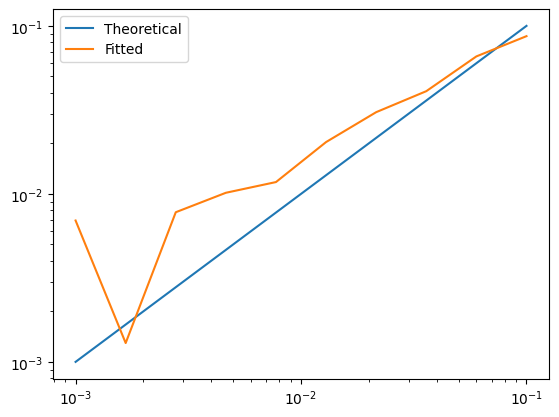

In [21]:
sigspace = np.logspace(-3, -1, 10)
plt.plot(sigspace, sigspace, label = "Theoretical")
plt.plot(sigspace, np.exp(weight_list3), label = "Fitted")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [16]:
# plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
# plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
# plt.xscale("log")
# plt.xlabel("S/B")
# plt.ylabel("Fitted masses [GeV]")
# plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
# plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
# plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
# plt.legend()
# plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

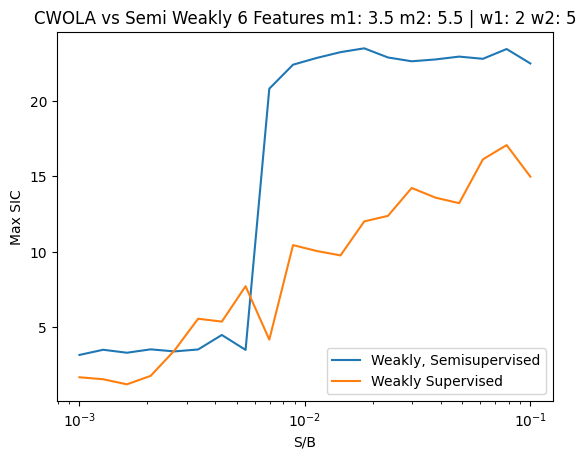

In [213]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

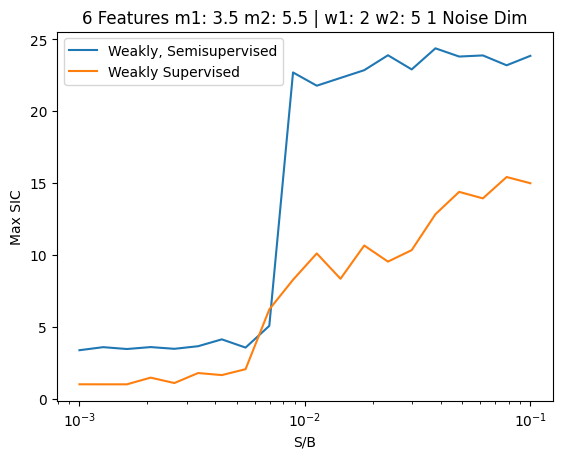

In [455]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2} 1 Noise Dim")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

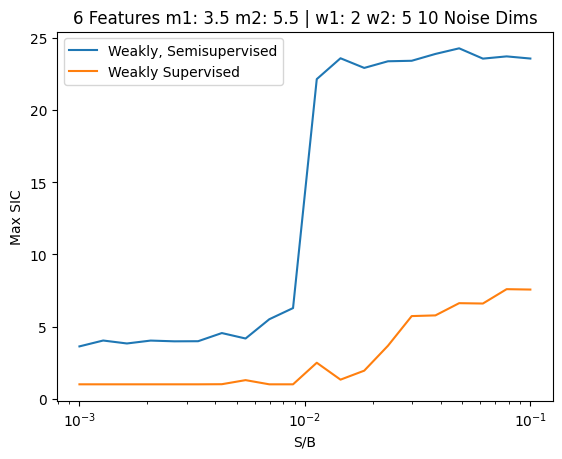

In [39]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2} 10 Noise Dims")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

In [14]:
#dedicated training on single mass pair
def train_supervised(feature_dims, m1, m2):
    tf.random.set_seed(42)
    np.random.seed(42)
    x_data_full = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
    y_data_full = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
    X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5, random_state = 42, shuffle=False)

    model_dedicated = Sequential()
    model_dedicated.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(1, activation='sigmoid'))
    model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

    history_fullySupervised = model_dedicated.fit(X_train_full, Y_train_full, epochs=100,validation_data=(X_val_full, Y_val_full),batch_size=1024, verbose = 0)
    preds = model_dedicated.predict(X_val_full,batch_size=1000)
    fpr, tpr, _ = metrics.roc_curve(Y_val_full, preds)
    maxsic_full = np.max(tpr/np.sqrt(fpr+epsilon))
    return maxsic_full

#CWOLA comparison
def compileCWOLA(feature_dims, m1, m2):
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_cwola

from tensorflow.keras.constraints import Constraint
class WeightConstraint(Constraint):
    def __init__(self, min_value=0.5, max_value=6):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value}

#SemiWeak Model
def compileSemiWeakly(model, feature_dims, params, m1, m2, w1, w2):
        
    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_constraint=WeightConstraint())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_constraint=WeightConstraint())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    epsilon = 1e-4
    #physics prior
    hidden_layer_1 = model(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)

    if params == 2:
        LLR_xs = 1.+sigfrac*LLR - sigfrac
    elif params == 3:
        LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    else:
        print("Choose 2 or 3 parameters")
    ws = LLR_xs / (1.+LLR_xs)

    SemiWeakModel = Model(inputs = inputs, outputs = ws)
    SemiWeakModel.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))
    return SemiWeakModel

In [20]:
#Loop over signal injection amounts M
#For a given signal injection amount, inject events according to N ~ Poission(M)
#For a given N injected events, initialize the network with w ~ Uniform.  Do this k times.

noise = False
epsilon = 1e-4
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations):
    maxsicandstd1 = {}
    maxsicandstd2 = {}
    msic1_runs = []
    msic2_runs = []
    std1_runs = []
    std2_runs = []
    score1_injections_raw_runs = []
    score2_injections_raw_runs = []
    weight_list1_runs = []
    weight_list2_runs = []
    weight_list3_runs = []
    initial_weights_runs = []
    
    qq = "qq"
    test_signal = int(1/2*len(x[m1,m2, qq, noise]))

    sigspace = np.flip(np.logspace(-3,-1,10))
    for sigfrac in sigspace:

        initial_weights = []

        msic1_median = []
        msic2 = []
        score1_injections = []
        score2_injections = []
        weight_list1_injections = []
        weight_list2_injections = []
        weight_list3_injections = []

        print(f"---------------{sigfrac}---------------")

        # N ~ Poission(M) injected events
        for injection in range(injections):
            print(f"Injecting N = {injections - injection} more times, currently on: N = {injection}")

            #randomized signal
            random_test_signal_length = random.randint(0, test_signal - 1)
            N = int(1/4 * (len(x[0,0, qq, noise])))
            signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

            #fixed signal portion
            # N = int(1/4 * (len(x[0,0, qq, noise])))
            # signal = x[m1, m2, qq, noise][test_signal:test_signal + int(sigfrac*N)]

            score1_kruns = []
            weight_list1_kruns = []
            weight_list2_kruns = []
            weight_list3_kruns = []

            print(f"Ensembling {k_runs} for Signal Fraction : {sigfrac}")
            for k in range(k_runs):

                w1 = round(random.uniform(0.5, 6),3)
                w2 = round(random.uniform(0.5, 6),3)
                initial_weights.append((w1, w2))

                print(f"Initialization: {w1} {w2}")

                for l in model_qq.layers:
                    l.trainable=False
                model_semiweak = compileSemiWeakly(model_qq, feature_dims, params, m1, m2, w1, w2)

                test_background = int(1/2 * len(x[0,0, qq, noise]))
                train_reference = int(1/4 *len(x[0,0, qq, noise]))
                train_data = int(1/4 * len(x[0,0, qq, noise]))
                test_signal = int(1/2*len(x[m1,m2, qq, noise]))

                x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                history_semiweak = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_, epochs=100,
                                                       validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)

                print(f"m1: {m1}",f"m2: {m2}", f"w1: {model_semiweak.trainable_weights[0].numpy()[0][0]}", f"w2: {model_semiweak.trainable_weights[1].numpy()[0][0]}")

                weight_list1_kruns+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
                weight_list2_kruns+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
                weight_list3_kruns+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

                scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)

                #per-event probability
                score1_kruns.append(scores)

            #kruns finished
            weight_list1_injections.append(weight_list1_kruns)
            weight_list2_injections.append(weight_list2_kruns)
            weight_list3_injections.append(weight_list3_kruns)
            
            #now average over the k classifiers runs
            y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr, tpr, _ = metrics.roc_curve(y, np.median(score1_kruns, axis = 0))
            msic1_kmedian = np.max(tpr/np.sqrt(fpr+epsilon))
            score1_injections.append(score1_kruns)
            msic1_median.append(msic1_kmedian)
            print(f" --- msic1_median on injection {injection}: {msic1_kmedian} ---")
            
            #weakly supervised only inject no k classifiers (out of mass initialization loop) no averaging to be done yet
            model_CWOLA = compileCWOLA(feature_dims, m1, m2)
            history_CWOLA = model_CWOLA.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
            
            scores2 = model_CWOLA.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
            score2_injections.append(scores2)
            
            y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
            msic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))
        
        msic1_runs.append(np.median(msic1_median))
        print(f" --- msic1_runs for signal fraction {sigfrac}: {np.median(msic1_median)} ---")
        std1_runs.append(np.std(msic1_median))
        print(f" --- msic1_runs_std for signal fraction {sigfrac}: {np.std(msic1_median)} ---")
        
        print(f" --- msic2_runs for signal fraction {sigfrac}: {np.median(msic2)} ---")
        std2_runs.append(np.std(msic2))
        print(f" --- msic2_runs_std for signal fraction {sigfrac}: {np.std(msic2)} ---")
        msic2_runs.append(np.median(msic2))
        
        score1_injections_raw_runs.append(score1_injections)
        score2_injections_raw_runs.append(score2_injections)
        weight_list1_runs.append(weight_list1_injections)
        weight_list2_runs.append(weight_list2_injections)
        weight_list3_runs.append(weight_list3_injections)
        
        maxsicandstd1[sigfrac] = (np.median(msic1_median), np.std(msic1_median))
        maxsicandstd2[sigfrac] = (np.median(msic2), np.std(msic2))
        np.save(f"data/maxsicandstd1_notebook{float(m1)}{float(m2)}.npy", maxsicandstd1)
        np.save(f"data/maxsicandstd2_notebook{float(m1)}{float(m2)}.npy", maxsicandstd2)

    np.save(f"data/msic1_median_notebook{float(m1)}{float(m2)}.npy", maxsicandstd1)
    np.save(f"data/msic2_median_notebook{float(m1)}{float(m2)}.npy", maxsicandstd2)
    np.save(f"data/std1_median_notebook{float(m1)}{float(m2)}.npy", std1_runs)
    np.save(f"data/std2_median_notebook{float(m1)}{float(m2)}.npy", std2_runs)
    np.save(f"data/weight_list1_runs_notebook{float(m1)}{float(m2)}.npy", weight_list1_runs)
    np.save(f"data/weight_list2_runs_notebook{float(m1)}{float(m2)}.npy", weight_list2_runs)
    np.save(f"data/weight_list3_runs_notebook{float(m1)}{float(m2)}.npy", weight_list3_runs)
    np.save(f"data/initial_weights_runs_notebook{float(m1)}{float(m2)}.npy", initial_weights_runs)

In [36]:
#fully supervised dedicated training initiaized once
msic_full = train_supervised(6, 5, 1)
print("FS Max Sic: ",msic_full)
#parametrized classifer
scores_parameterized = model_qq.predict(x_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1],batch_size=1000)
fpr_param, tpr_param, _ = metrics.roc_curve(y_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1], scores_parameterized)
msic_param = np.max(tpr_param/np.sqrt(tpr_param+epsilon))
print("Parametrized Max Sic: ", msic_param)

In [ ]:
#mass initializations
k_runs = 5
feature_dims = 6
params = 3
#number of randomized signal injection
injections = 10

m1 = 3
m2 = 3

parameters = params
m_initializations = k_runs

train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations)

---------------0.1---------------
Injecting N = 10 more times, currently on: N = 0
Ensembling 5 for Signal Fraction : 0.1
Initialization: 3.539 3.0
m1: 3 m2: 3 w1: 3.016065835952759 w2: 3.0400266647338867
96/96 [==============================] - 0s 951us/step
Initialization: 5.749 1.185
m1: 3 m2: 3 w1: 5.6111063957214355 w2: 0.9122120141983032
96/96 [==============================] - 0s 964us/step
Initialization: 5.146 4.655
m1: 3 m2: 3 w1: 2.9991633892059326 w2: 3.0136795043945312
96/96 [==============================] - 0s 941us/step
Initialization: 4.297 3.221
m1: 3 m2: 3 w1: 3.00634503364563 w2: 3.0272202491760254
96/96 [==============================] - 0s 946us/step
Initialization: 2.259 4.831
m1: 3 m2: 3 w1: 2.9946162700653076 w2: 3.0149271488189697
96/96 [==============================] - 0s 927us/step
 --- msic1_median on injection 0: 27.78375476672408 ---
96/96 [==============================] - 0s 655us/step
Injecting N = 9 more times, currently on: N = 1
Ensembling 5 for Si

In [29]:
#take median scores and calculate maxsics
def calculate_maxsics_median(scores):
    msic = []
    for score in scores:
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr, tpr, _ = metrics.roc_curve(y, score)
        msic.append(np.max(tpr/np.sqrt(fpr+epsilon)))
    return msic

#given raw scores from k classifiers
# def calculate_maxsics_raw(scores):
#     for M in scores:
#         for injection in M:
#             k_median_score = []
#             for k in injection:
#                 k_median_score.append(np.median(k))

In [51]:
msic1_runs

[[3.6747026970107792,
  2.238937017158614,
  3.635456006920292,
  2.827954506118482,
  3.440439796157649,
  9.249681620643484,
  2.85009947086245,
  2.842478198995669,
  2.8367925870702946,
  2.7279056097020655],
 [2.837589900410779,
  2.607262510389001,
  10.097266590725049,
  2.6823017177800965,
  2.854743955216265,
  1.8729039715492293,
  2.2312175130963463,
  2.5623244631314366,
  2.1335302879835223,
  2.075528205964069],
 [3.828463815501879,
  2.2814008755420954,
  3.2182552362248593,
  2.3084166669943915,
  2.154918303477763,
  2.390413804466631,
  1.687297359243335,
  2.508239028152515,
  2.2415476129935046,
  2.541596334399813],
 [23.617780024148484,
  3.0552639708941824,
  2.7359936865406023,
  23.03678566656365,
  22.963020742879486,
  3.526450581729274,
  2.1660411867893243,
  3.0459609654966893,
  3.4098835982966276,
  2.1502109055021914],
 [2.790667309235144,
  4.346258783778534,
  2.6130130232496387,
  1.872896350878266,
  1.9643027978963363,
  1.711619243640931,
  22.312

In [46]:
msic3_runs = np.max(tpr_full/np.sqrt(fpr_full+epsilon))
msic4_runs = np.max(tpr_full2/np.sqrt(fpr_full2+epsilon))

In [126]:
# import math
# poisson = lambda l, k : (l**k * np.exp(l))/(math.factorial(k))
# sig_space = np.logspace(-3,-1,10)

# points = []
# for sigfrac in sig_space:
#     random_test_signal_length = random.randint(0, test_signal - 1)
#     N = int(1/4 * (len(x[0,0, qq, noise])))
#     signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]
#     points.append(poisson(len(signal), len(sig_space)))
    
# plt.plot(sig_space,points)

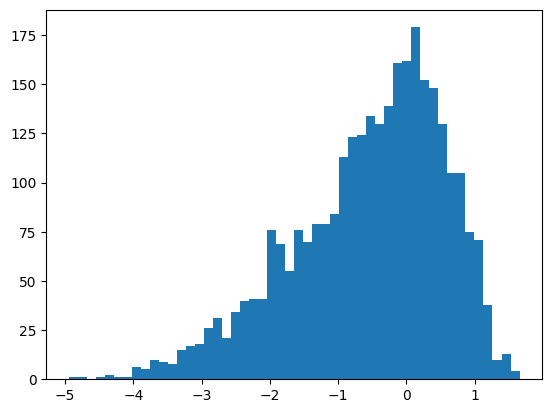

In [56]:
plt.hist(x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)][:,5], bins = 50);

In [49]:
len(x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)][:,0])

3033

Text(0, 0.5, 'Avg Max SIC')

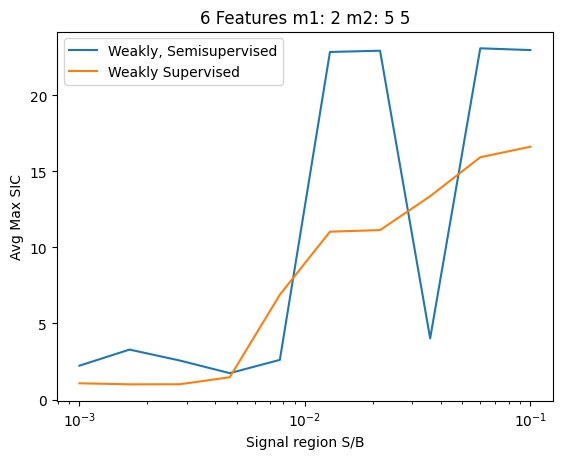

In [27]:
avgmsic1 = np.median(msic1_runs, axis = 1)
avgmsic2 = np.median(msic2_runs, axis = 1)
# avgmsic3 = np.median(msic3_runs, axis = 1)
# avgmsic4 = np.median(msic4_runs, axis = 1)

plt.plot(sigspace,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sigspace,avgmsic2,label="Weakly Supervised")
# plt.plot(sig_list,avgmsic3,label="Fully Supervised")
# plt.plot(sig_list,avgmsic4,label="Fully Supervised")

plt.title(f"6 Features m1: {m1} m2: {m2} {k_runs}")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

Text(0, 0.5, 'Avg Max SIC')

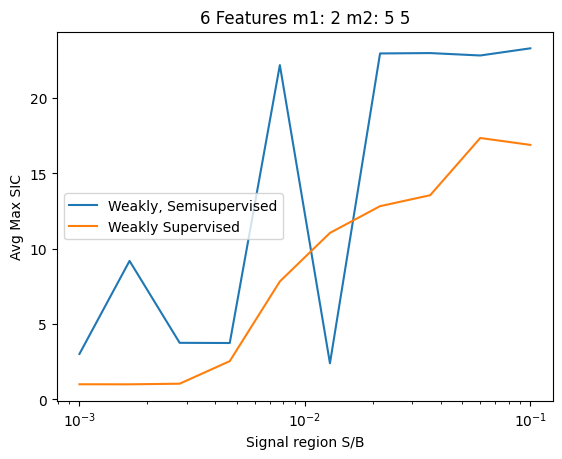

In [42]:
avgmsic1 = np.median(msic1_runs, axis = 1)
avgmsic2 = np.median(msic2_runs, axis = 1)
# avgmsic3 = np.median(msic3_runs, axis = 1)
# avgmsic4 = np.median(msic4_runs, axis = 1)

plt.plot(sigspace,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sigspace,avgmsic2,label="Weakly Supervised")
# plt.plot(sigspace,avgmsic3,label="Fully Supervised")
# plt.plot(sigspace,avgmsic4,label="Fully Supervised")

plt.title(f"6 Features m1: {m1} m2: {m2} {k_runs}")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [47]:
max_sics = {}
max_sics[("SWS", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic1_runs
max_sics[("WS", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic2_runs
max_sics[("FS", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic3_runs
max_sics[("FP", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic4_runs

import pickle
with open('max_sics25loopstructure6.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [79]:
np.save("25loopstructure2.npy", weight_list3_runs)

In [27]:
import time

qq = "qq"
noise = False

start_time = time.time()

def eval_loss_landscape_6Features(model,feature_dims, parameters, m1, m2, step):
    
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_{feature_dims}_{parameters}_{m1}_{m2}_{step}.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    #varying sigfrac, fixed mass pair
    
    losses_list = []

    epsilon = 1e-4
    sig_space = [np.logspace(-3, -1, 10)[-1]]
    
    #if we want a specific sigfrac
    sig_space = [0.1]
    
    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 100 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)
                sigfrac = sig

                model_semiweak = compileSemiWeakly(model, feature_dims, 2, m1, m2, w1, w2)

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq, noise]))
                train_background = int(1/4 * len(x[0,0,qq, noise]))
                train_data = int(1/4 * len(x[0,0,qq, noise]))
                train_reference = int(1/4 * len(x[0,0,qq, noise]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

                #randomize signal events
                random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq, noise])))
                signal = x[m1, m2,qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_semiweak.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Loss Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
    end_time_total = time.time()

    elapsed_time_total = round(end_time_total - start_time, 3)
    print(f"Total elapsed time: {elapsed_time_total} seconds")

In [28]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
eval_loss_landscape_6Features(model_qq, 6, 3, 5, 1, 0.25)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
reached 0.5 0.5
reached 1.5 2.5
reached 2.5 4.5
reached 3.75 0.75
reached 4.75 2.75
reached 5.75 4.75
Time taken: 772.918 seconds
Total elapsed time: 772.945 seconds


In [29]:
x[1, 1, qq, False]

array([[-1.1467854 , -1.47770924, -0.06188168, -1.25308806,  0.34378257,
        -0.18466159],
       [-1.1487145 , -1.69706728, -0.68294717,  0.03500569, -1.06319069,
         0.43469069],
       [-1.13268386, -1.55028145, -1.34432782, -0.39714657, -0.953696  ,
        -1.60115472],
       ...,
       [-1.17579285, -1.62957953, -0.78923019, -1.31430044, -1.73511428,
        -0.82381764],
       [-1.19046974, -1.71033063, -0.4539729 ,  0.11360652, -0.80338618,
         0.44749405],
       [-1.23125368, -1.64679808, -1.99324816, -1.64119963, -0.33379286,
         0.3691295 ]])

In [30]:
qq

'qq'

In [37]:
qq = "qq"
noise = False

start_time = time.time()

def eval_AUC_landscape_6Features(model, feature_dims, parameters, m1, m2, step = 0.25):
    
    #check if AUC dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"a_{feature_dims}{parameters}{m1}{m2}{step}.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        a = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        a = {}
    #varying sigfrac, fixed mass pair
    
    AUC_list = []

    epsilon = 1e-4
    sig_space = [np.logspace(-3, -1, 10)[-1]]
    
    #if we want a specific sigfrac
    #sig_space = [0.1]
    
    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 100 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)
                sigfrac = sig

                model_semiweak = compileSemiWeakly(model, feature_dims, parameters, m1, m2, w1, w2)

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in a:
                    break

                test_background = int(1/2 *len(x[0,0, qq, noise]))
                train_background = int(1/4 * len(x[0,0,qq, noise]))
                train_data = int(1/4 * len(x[0,0,qq, noise]))
                train_reference = int(1/4 * len(x[0,0,qq, noise]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

                #randomize signal events
                random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq, noise])))
                signal = x[m1, m2,qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    y_val_pred = model_semiweak.predict(X_val_)
                    auc = roc_auc_score(Y_val_, y_val_pred)
                AUC_list.append(auc)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in a:
            print("AUC Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            a[sigfrac, m1, m2] = AUC_list
            AUC_list = []
            np.save(file_name, a)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Total elapsed time: 0.0 seconds


In [39]:
from sklearn.metrics import roc_auc_score
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
eval_AUC_landscape_6Features(model_qq, 6, 3, 5, 1, 0.25)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
reached 0.5 0.5
996/996 [==============================] - 1s 1ms/step
reached 1.5 2.5
996/996 [==============================] - 1s 955us/step
reached 2.5 4.5
996/996 [==============================] - 1s 987us/step
reached 3.75 0.75
996/996 [==============================] - 1s 976us/step
reached 4.75 2.75
996/996 [==============================] - 1s 989us/step
reached 5.75 4.75
996/996 [==============================] - 1s 982us/step
Time taken: 1068.048 seconds


In [31]:
create_loss_landscape_6Features(6, model_qq, 1, 5.5)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
reached 0.5 0.5


NameError: name 'sigfrac' is not defined

In [23]:
z_allm1m2_HD = np.load("z_allm1m2_6FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_HD.keys()

dict_keys([(0.0379269019073225, 3, 4.5), (0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5)])

In [31]:
from IPython.display import display, clear_output
from PIL import Image, ImageSequence
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sb}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        # Append the image to the frames list
        frames.append(Image.open(image_path))

    # Create the final GIF that combines all frames
    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)

In [16]:
X_train_qqq, X_val_qqq, Y_train_qqq, Y_val_qqq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5)

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [7]:
model_qq = tf.keras.models.load_model("model_qq_v2")
model_qqq = tf.keras.models.load_model("model_qqq")

2024-01-09 21:32:41.982684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 21:32:43.758591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13379 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [54]:
from models import createSimpleModel

decay = "qqq"
qq = "qq"

sigmoid = lambda x: 1. / (1. + np.exp(-x))

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
weight_list4_runs = []
initial_weights_list_runs = []

num_runs = 1

for _ in range(num_runs):

    sig_list = []
    
    msic1 = []
    msic2 = []
    msic3 = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    weight_list4 = []

    sigspace = np.logspace(-3, -1, 20)

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    initial_weights_list_runs.append((w1, w2))

    #print(w1, w2)
    for sigfrac in sigspace:

        #freeze both two pronged and three pronged prior models
        for l in model_qq.layers:
            l.trainable=False

        for l in model_qqq.layers:
            l.trainable=False

        #sigfrac = 0.1
        print(sigfrac, w1, w2)

        #w1, w2 = 3.241, 3.649 

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs_hold4 = tf.keras.Input(shape=(1,))
        simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
        model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        hidden_layer_13 = model_qqq(inputs2)
        LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
        LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
        #LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0])
        ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 1
        m2 = 5.5

        test_background = int(1/2 * len(x[0,0, decay]))
        train_reference = int(1/4 *len(x[0,0, decay]))
        train_data = int(1/4 * len(x[0,0, decay]))
        test_signal = int(1/2*len(x[m1,m2, decay]))
        sig_frac = sigfrac

        #randomize signal events
        # random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0, decay])))
        # signal = x[m1, m2, decay][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #mix both samples
        signal_mixed = np.concatenate([x[m1, m2, decay][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))], x[m1, m2, qq][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))]])
        background_mixed = np.concatenate([x[0,0,decay][:int(test_background/2)], x[0,0,qq][:int(test_background/2)]])
        
        # x_data_ = np.concatenate([x[0,0,decay][test_background:],signal])
        # y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
        
        x_data_mixed = np.concatenate([background_mixed,signal_mixed])
        y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])
        
        #noise?
        # samples = np.shape(x_data_mixed)[0]
        # random_samples = np.random.normal(0, 1, samples)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        sig_list+=[sigfrac]
        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        weight_list4+=[sigmoid(model_all2.trainable_weights[3].numpy()[0][0])]

        #scores = model_all2.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:test_signal]]),batch_size=1024, verbose = 0)
        #scores_mixed = model_all2.predict(x[0,0,decay][0:int(test_background/2)], signal_mixed,batch_size=1024, verbose = 0)
        #y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        #fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        # model_cwola = Sequential()
        # model_cwola.add(Dense(128, input_dim=6, activation='relu'))
        # model_cwola.add(Dense(128, activation='relu'))
        # model_cwola.add(Dense(128, activation='relu'))
        # model_cwola.add(Dense(1, activation='sigmoid'))
        # model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)

        #scores2 = model_cwola.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:test_signal]]),batch_size=1024)
        #scores2_mixed = model_cwola.predict([background_mixed,signal_mixed],batch_size=1024)
        #y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        #fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
#         #fully supervised
        scores_full = model_dedicated.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
        y_full = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)
        
#         msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
#         msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
#         msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])
        
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    #msic3_runs.append(msic3)
    weight_list3_runs.append(weight_list3)
    weight_list4_runs.append(weight_list4)

In [137]:
initial_weights_list_runs

[(3.067, 3.45), (1.705, 4.476), (3.225, 5.053), (5.711, 3.199), (3.922, 2.867)]

In [84]:
np.shape(x[0,0,qq][:int(test_background/2)])

(30338, 6)

In [30]:
x[0,0,qqq][int(test_background/2):]

array([[-1.11881922, -1.66852576,  1.57244427,  1.20983769, -0.13939007,
         0.85941707],
       [-1.12420602, -1.26681214,  0.82536103,  0.1229807 ,  0.30860917,
         0.13311748],
       [-1.14769921, -0.50415523,  1.43958292,  0.62034086,  0.19901901,
        -1.04425623],
       ...,
       [-0.96736856, -1.48238533,  1.25622683, -0.47599974, -0.32423304,
         0.86060971],
       [-1.3598598 , -1.72354998,  1.79953958,  1.20194427,  0.44119858,
         0.28992835],
       [-1.42887276, -1.6890858 ,  0.89151195,  0.58091326,  1.22563292,
         0.4144562 ]])

In [110]:
x[0,0,qq][int(test_background/2):] == x[0,0,qqq][int(test_background/2):]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [35]:
np.array_equal(x[0,0,qq][int(test_background/2):], x[0,0,qqq][int(test_background/2):])

True

In [26]:
int(test_background/2) + int(test_background/2) == test_background

True

In [196]:
np.save("3ProngWeight_List3_Runs33_randomized", weight_list3_runs)
np.save("3ProngWeight_List4_Runs33_randomized", weight_list4_runs)

Text(0, 0.5, 'Avg Max SIC')

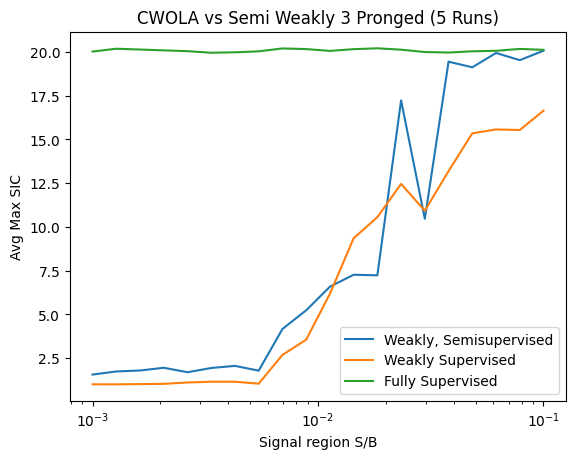

In [202]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly 3 Pronged ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [107]:
initial_weights_list_runs

[(3.564, 1.382)]

In [159]:
avgww = np.median(weight_list3_runs, axis = 0)
avgww2 = np.median(weight_list4_runs, axis = 0)

plt.plot(sig_list,weight_list3,label=r"$\mu$")
plt.plot(sig_list,weight_list4,label=r"$\alpha$")
plt.plot(sig_list,sig_list,ls=":",color="black")

plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

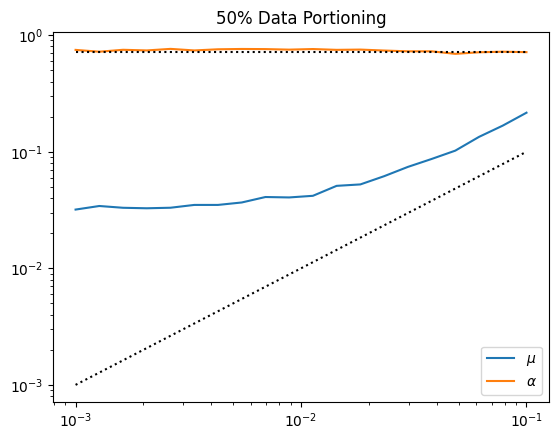

In [142]:
plt.plot(sig_list,weight_list3,label=r"$\mu$")
plt.plot(sig_list,weight_list4,label=r"$\alpha$")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.plot(sig_list, [weight_list4[19]]*20, ls = ":", color = "black")
plt.title("50% Data Portioning")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [161]:
weight_list4

[0.7949729094565375,
 0.7967428042435447,
 0.7633858522721106,
 0.7183202970246372,
 0.7286010241365904,
 0.8059874435095145,
 0.7859716109884602,
 0.7620331165145308,
 0.7544795437582383,
 0.7142845860567203,
 0.7264332030386054,
 0.7649021788557809,
 0.7848433666572873,
 0.7418548081439902,
 0.7345575889763402,
 0.7782074477116568,
 0.8123507782533296,
 0.8373520277157607,
 0.8798965231515105,
 0.8941288071840675]

(0.0, 700.0)

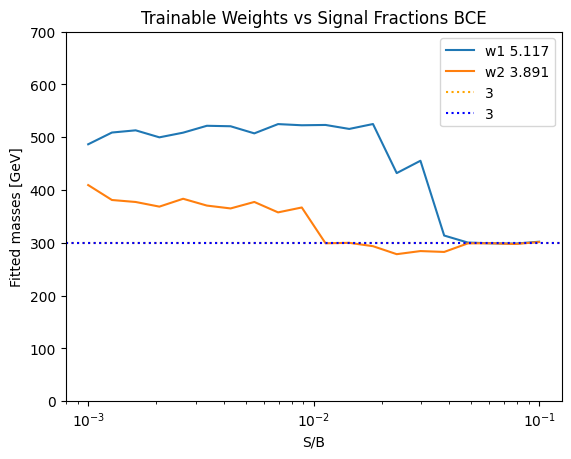

In [205]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [199]:
max_sics = {}
max_sics[("SWS", 6, 4, m1, m2)] = msic1_runs
max_sics[("WS", 6, 4, m1, m2)] = msic2_runs
max_sics[("FS", 6, 4, m1, m2)] = msic3_runs

import pickle
with open('max_sics_3prong33randomized.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [21]:
if (True):
    
    model_qqq = Sequential()
    model_qqq.add(Dense(256, input_dim=8, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(256, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(256, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(1, activation='sigmoid'))
    model_qqq.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    myhistory_qqq = model_qqq.fit(X_train_qqq, Y_train_qqq, epochs=500,validation_data=(X_val_qqq, Y_val_qqq),batch_size=5*1024,callbacks=[es])
    
    plt.plot(myhistory_qqq.history['val_loss'][1:])
    plt.plot(myhistory_qqq.history['loss'][1:])
    
    model_qqq.save('model_qqq')

Epoch 1/500
2692/2692 [==============================] - 11s 4ms/step - loss: 0.1674 - accuracy: 0.9340 - val_loss: 0.1564 - val_accuracy: 0.9386
Epoch 2/500
2692/2692 [==============================] - 9s 4ms/step - loss: 0.1542 - accuracy: 0.9391 - val_loss: 0.1539 - val_accuracy: 0.9393
Epoch 3/500
2692/2692 [==============================] - 9s 3ms/step - loss: 0.1530 - accuracy: 0.9396 - val_loss: 0.1529 - val_accuracy: 0.9396
Epoch 4/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1523 - accuracy: 0.9398 - val_loss: 0.1525 - val_accuracy: 0.9399
Epoch 5/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1518 - accuracy: 0.9400 - val_loss: 0.1517 - val_accuracy: 0.9400
Epoch 6/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1514 - accuracy: 0.9402 - val_loss: 0.1511 - val_accuracy: 0.9404
Epoch 7/500
2692/2692 [==============================] - 9s 4ms/step - loss: 0.1511 - accuracy: 0.9403 - val_loss: 0.1517 - va

KeyboardInterrupt: 

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qqq = Sequential()
model_qqq.add(Dense(256, input_dim=8, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(256, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(256, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qqq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qqq = model_qqq.fit(X_train_qqq, Y_train_qqq, epochs=5000,validation_data=(X_val_qqq, Y_val_qqq),batch_size=5*1024,callbacks=[es])

Epoch 1/5000
2692/2692 [==============================] - 13s 4ms/step - loss: 0.2904 - accuracy: 0.8848 - val_loss: 0.2361 - val_accuracy: 0.9107
Epoch 2/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.2222 - accuracy: 0.9152 - val_loss: 0.2095 - val_accuracy: 0.9189
Epoch 3/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.2026 - accuracy: 0.9209 - val_loss: 0.1963 - val_accuracy: 0.9230
Epoch 4/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1926 - accuracy: 0.9242 - val_loss: 0.1890 - val_accuracy: 0.9256
Epoch 5/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1866 - accuracy: 0.9265 - val_loss: 0.1841 - val_accuracy: 0.9274
Epoch 6/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1824 - accuracy: 0.9281 - val_loss: 0.1803 - val_accuracy: 0.9291
Epoch 7/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1792 - accuracy: 0.9294 - val_loss: 0

KeyboardInterrupt: 

In [56]:
#model_qqq.save('model_qqq')

INFO:tensorflow:Assets written to: model_qqq/assets
